In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score

from graspy.plot import heatmap
from graspy.utils import get_multigraph_intersect_lcc, is_symmetric

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from utils import estimate_block_assignment, permute_edges, block_permute, permute_matrix, triu_no_diag, to_distance_mtx, identity, power

### Preprocessing

In [2]:
chem_male = pd.read_csv('../celegans_data/male_chem_A_full_undirected.csv', header=None).values
gap_male = pd.read_csv('../celegans_data/male_gap_A_full_undirected.csv', header=None).values

In [3]:
chem_male.shape

(575, 575)

In [4]:
gap_male.shape

(585, 585)

In [5]:
chem_male, gap_male = get_multigraph_intersect_lcc([chem_male, gap_male])

chem_male = np.where(chem_male > 0, 1, 0).astype(float)
gap_male = np.where(gap_male > 0, 1, 0).astype(float)

In [6]:
chem_male.shape

(455, 455)

In [7]:
chem_cell = pd.read_csv('../celegans_data/male_chem_full_cells.csv', header=None)
gap_cell = pd.read_csv('../celegans_data/male_gap_full_cells.csv', header=None)

chem_cell = np.squeeze(chem_cell.values)
gap_cell = np.squeeze(gap_cell.values)

gap_not_chem = set(gap_cell) - set(chem_cell)
chem_not_gap = set(chem_cell) - set(gap_cell)

In [8]:
len(gap_not_chem)

18

In [9]:
len(chem_not_gap)

8

In [34]:
random_state = None
num_rep = 500
rand = np.zeros(num_rep)
for i in tqdm(range(num_rep)):
    ba1 = estimate_block_assignment(chem_male, gap_male, k=10, svd='randomized', random_state=random_state)
    ba2 = estimate_block_assignment(chem_male, gap_male, k=10, svd='randomized', random_state=random_state)
    rand[i] = adjusted_rand_score(ba1, ba2)

100%|██████████| 500/500 [05:48<00:00,  1.47it/s]


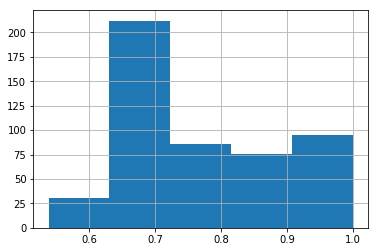

In [50]:
plt.hist(rand, bins=5)
plt.grid()

In [39]:
rep = 500
num_blocks = np.zeros(rep)
for i in tqdm(range(rep)):
    block_assignment = estimate_block_assignment(chem_male, gap_male, k=10)
    num_blocks[i] = np.unique(block_assignment).size

100%|██████████| 500/500 [03:02<00:00,  2.64it/s]


In [44]:
np.arange(np.amin(num_blocks), np.amax(num_blocks)+2)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

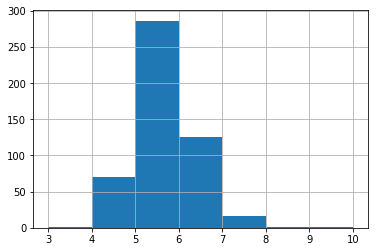

In [51]:
plt.hist(num_blocks, bins=np.arange(np.amin(num_blocks), np.amax(num_blocks)+2))
plt.grid()

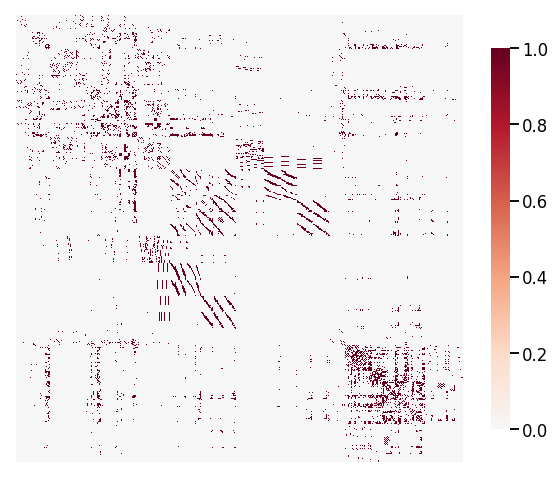

In [52]:
heatmap(chem_male)

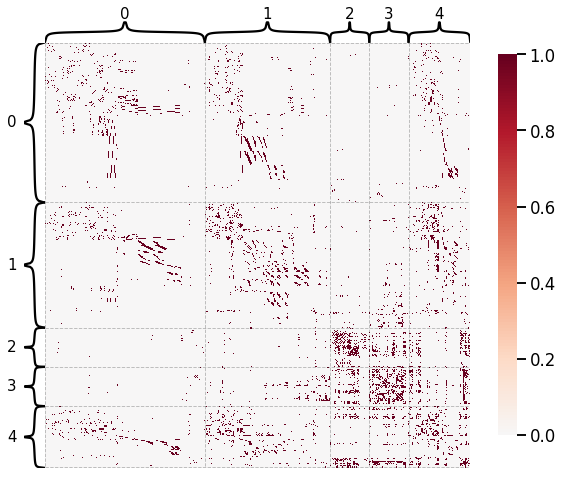

In [32]:
heatmap(chem_male, inner_hier_labels=block_assignment)

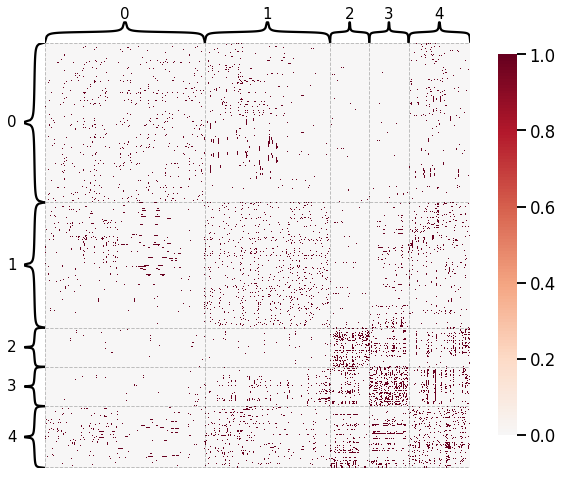

In [27]:
heatmap(block_permute(chem_male, block_assignment), inner_hier_labels=block_assignment)

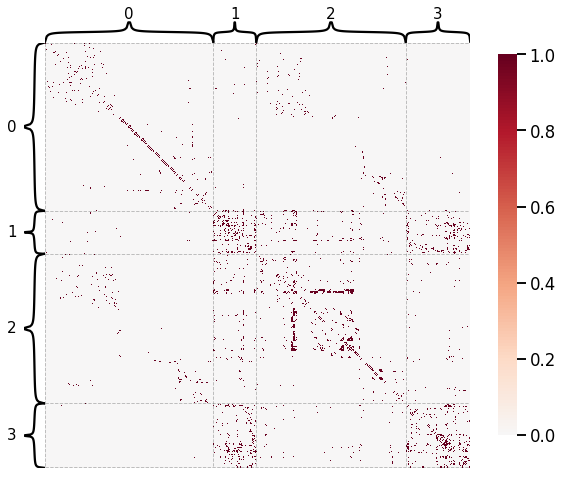

In [13]:
heatmap(gap_male, inner_hier_labels=block_assignment)

### Fit model

In [14]:
mgc = MGC(compute_distance_matrix=identity)

In [15]:
def pvalue(A, B, indept_test, transform_func, k=10, null_mc=500):
    test_stat_alternative, _ = indept_test.test_statistic(
        matrix_X=transform_func(A), matrix_Y=transform_func(B))

    block_assignment = estimate_block_assignment(A, B, k=k)
    num_block = np.unique(block_assignment).size
    
    test_stat_null_array = np.zeros(null_mc)
    for j in tqdm(range(null_mc)):
        A_null = block_permute(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B))
        test_stat_null_array[j] = test_stat_null

    p_value = np.where(test_stat_null_array > test_stat_alternative)[
        0].shape[0] / test_stat_null_array.shape[0]
    return p_value, num_block

In [16]:
pval, num_block = pvalue(A=chem_male, B=gap_male, indept_test=mgc, transform_func=to_distance_mtx)

100%|██████████| 500/500 [04:42<00:00,  1.92it/s]


In [17]:
pval

0.094

In [18]:
num_block

5

In [19]:
mgc.test_statistic(to_distance_mtx(chem_male), to_distance_mtx(gap_male))

(0.03714785081262196,
 {'local_correlation_matrix': array([[0.03714785, 0.03484336],
         [0.03534879, 0.03293405]]), 'optimal_scale': [1, 1]})